# Testing for genotype without considering disease time

### Logistics

In [1]:
#install libraries if not already
%pip install -r ../requirements.txt
%clear


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# load necessary library
import os
import pandas as pd
import numpy as np
from pipeline import ClusterFeatures,LBP_3D,XGBoost,XGBoostP,create_report_summary,NaiveBayesP,NaiveBayes,SVM,SVMP
from sklearn.model_selection import train_test_split


In [3]:
# load dataset
csv_dir = '../../Datasets/Rat PA Study/CSV/'
csv_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]

dataframes = []
for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    dataframes.append([pd.read_csv(file_path),file_path])


#load report features
source = '../../Datasets/Rat PA Study/PDF_reports/'



report_summary = create_report_summary(source)


for idx,row in enumerate(dataframes):
    path=row[1].split('/')[5].split('.')[0]
    report_row = report_summary[report_summary['ScanName']==path]
    report_row=report_row.drop(columns=['ScanName','DatePrepared','FileName'])
    dataframes[idx].append(report_row)



In [ ]:
# load dataset
csv_dir = '../../Datasets/Rat Sterile Bead Study/csv/baseline'
csv_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]

dataframes_all = []
for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    dataframes_all.append([pd.read_csv(file_path),file_path])


#load report features
source = '../../Datasets/Rat Sterile Bead Study/PDF_report/baseline'



report_summary = create_report_summary(source)


for idx,row in enumerate(dataframes_all):
    path=row[1].split('/')[6].split('.')[0]
    report_row = report_summary[report_summary['FileName'].str.contains(path)]
    report_row=report_row.drop(columns=['ScanName','DatePrepared','FileName'])
    dataframes_all[idx].append(report_row)



[      Specific Ventilation (mL/mL)    x (mm)    y (mm)   z (mm)
0                         0.021654 -0.476610 -10.00880 -16.6547
1                         0.053881  0.476612 -10.00880 -16.6547
2                         0.024212  1.429830 -10.00880 -16.6547
3                         0.019765  2.383060 -10.00880 -16.6547
4                         0.113660 -0.476610  -9.05562 -16.6547
...                            ...       ...       ...      ...
8240                      0.253957  4.289500 -15.72820  21.4742
8241                      0.135875  6.195950 -17.63460  22.4274
8242                      0.175927  3.336280 -16.68140  22.4274
8243                      0.222575  4.289500 -16.68140  22.4274
8244                      0.247715  5.242720 -16.68140  22.4274

[8245 rows x 4 columns], '../../Datasets/Rat Sterile Bead Study/csv/baseline/S187.WT.specificVentilation.csv',     VDP(%)  MSV(mL/mL)  TV(L)  VH(%)  VHSS(%)  VHLS(%)
20    13.8       0.182  1.307  45.52    17.72    31.19]


: 

: 

: 

In [4]:
#split data by genotypes
CF=[]
CF_report=[]

KO=[]
KO_report=[]

WT=[]
WT_report=[]

for df,path,report in dataframes:
    if 'WT' in path:
        WT.append(df)
        WT_report.append(report)
    if 'KO' in path:
        KO.append(df)
        KO_report.append(report)
    if 'CF' in path:
        CF.append(df)
        CF_report.append(report)


print(f'{len(CF)} CF rats, {len(KO)} KO rats, {len(WT)} WT rats ')

16 CF rats, 17 KO rats, 19 WT rats 


In [5]:
#split data by genotypes
CF_all=CF.copy()
CF_report_all=CF_report.copy()

KO_all=KO.copy()
KO_report_all=KO_report.copy()

WT_all=WT.copy()
WT_report_all=WT_report.copy()

for df,path,report in dataframes:
    if 'WT' in path:
        WT_all.append(df)
        WT_report_all.append(report)
    if 'KO' in path:
        KO_all.append(df)
        KO_report_all.append(report)
    if 'CF' in path:
        CF_all.append(df)
        CF_report_all.append(report)


print(f'{len(CF_all)} CF rats, {len(KO_all)} KO rats, {len(WT_all)} WT rats ')

32 CF rats, 34 KO rats, 38 WT rats 


# Modelling and Classification

### Using LBP

In [6]:
data=[]

for d in CF:
    d.columns=['SV','X','Y','Z']
    data.append([d,1])
for d in KO:
    d.columns=['SV','X','Y','Z']
    data.append([d,2])
for d in WT:
    d.columns=['SV','X','Y','Z']
    data.append([d,0])




lbp=LBP_3D(data)
features=lbp.extract()


In [7]:
def remove(feat,test,label):
    temp=feat[feat['Label']==label]
    t=temp.sample(n=1, random_state=np.random.randint(0, 1000))

    feat=feat.drop(t.index)
    test=pd.concat([test,t],ignore_index=True)

test=pd.DataFrame()

remove(features,test,0)
remove(features,test,1)
remove(features,test,2)




In [8]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

In [9]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)



Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         3
           2       0.67      0.50      0.57         4

    accuracy                           0.45        11
   macro avg       0.39      0.50      0.41        11
weighted avg       0.38      0.45      0.39        11

True: 0, Pred: 1, Probabilities: [0.06673479 0.5896604  0.34360483]
True: 1, Pred: 1, Probabilities: [0.0345239  0.95372194 0.01175415]
True: 0, Pred: 1, Probabilities: [0.03536157 0.94718975 0.01744862]
True: 1, Pred: 1, Probabilities: [0.19638966 0.79497355 0.0086368 ]
True: 0, Pred: 1, Probabilities: [0.31501663 0.6357957  0.04918761]
True: 2, Pred: 2, Probabilities: [0.13273998 0.33153754 0.53572243]
True: 2, Pred: 2, Probabilities: [0.03721525 0.03317815 0.92960656]
True: 1, Pred: 1, Probabilities: [0.24396825 0.6512175  0.10481416]
True: 2, Pred: 0, Probabilities: [0.8859345 

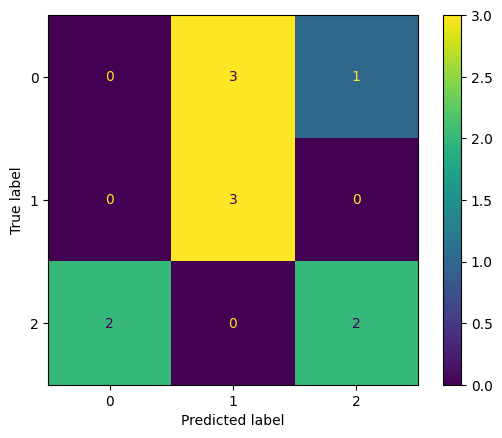

In [10]:
modelXG=XGBoost(X_train,y_train,X_test,y_test,True)
modelXGP=XGBoostP(X_train,y_train,X_test,y_test,True)

Classification Report: Naive Bayes (GaussianNB)
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.50      0.67      0.57         3
           2       0.50      0.25      0.33         4

    accuracy                           0.45        11
   macro avg       0.47      0.47      0.45        11
weighted avg       0.46      0.45      0.44        11

True: 0, Pred: 2, Probabilities: [0.05522359 0.06292742 0.88184899]
True: 1, Pred: 1, Probabilities: [5.39711146e-09 9.99999995e-01 1.07547865e-18]
True: 0, Pred: 1, Probabilities: [2.52167694e-08 9.99999975e-01 1.22222727e-18]
True: 1, Pred: 1, Probabilities: [4.19977809e-05 9.99958002e-01 1.35563983e-16]
True: 0, Pred: 0, Probabilities: [9.99539145e-01 4.60854714e-04 7.30339903e-14]
True: 2, Pred: 0, Probabilities: [7.18164580e-01 2.81601803e-01 2.33617155e-04]
True: 2, Pred: 2, Probabilities: [7.1063944e-11 5.0968738e-15 1.0000000e+00]
True: 1, Pred: 0, Probabil

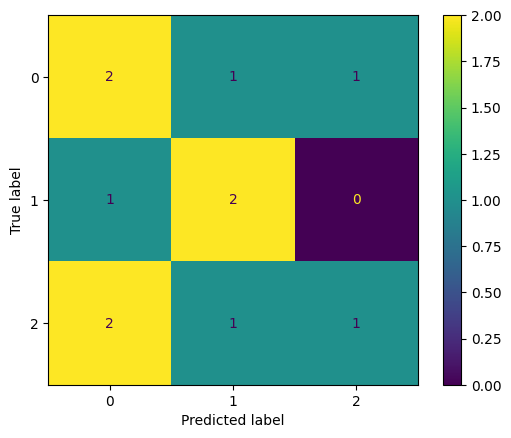

In [11]:
model=NaiveBayes(X_train,y_train,X_test,y_test,True)
modelP=NaiveBayesP(X_train,y_train,X_test,y_test,True)

Classification Report: SVC
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4

    accuracy                           0.36        11
   macro avg       0.12      0.33      0.18        11
weighted avg       0.13      0.36      0.19        11

True: 0, Pred: 0, Probabilities: [0.27703423 0.4070078  0.31595796]
True: 1, Pred: 0, Probabilities: [0.20462006 0.33179482 0.46358512]
True: 0, Pred: 0, Probabilities: [0.21404593 0.35242792 0.43352615]
True: 1, Pred: 0, Probabilities: [0.22678053 0.30726669 0.46595278]
True: 0, Pred: 0, Probabilities: [0.20083306 0.38179186 0.41737509]
True: 2, Pred: 0, Probabilities: [0.21871774 0.44202672 0.33925554]
True: 2, Pred: 0, Probabilities: [0.28581739 0.43638077 0.27780185]
True: 1, Pred: 0, Probabilities: [0.30131207 0.32285234 0.3758356 ]
True: 2, Pred: 0, Probabilities: [0.24054049 0.4

/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/spb/XV_Imaging/Code/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

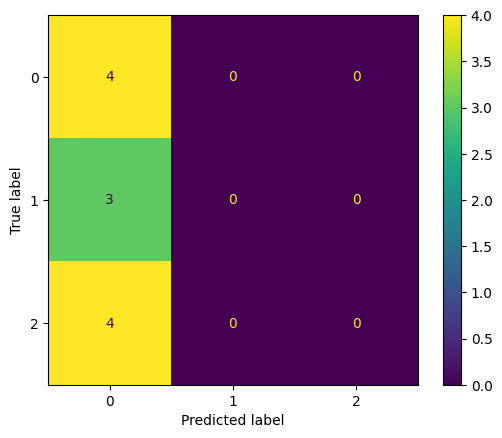

In [12]:
modelSVM=SVM(X_train,y_train,X_test,y_test,True)
modelSVWP=SVMP(X_train,y_train,X_test,y_test,True)

## Using report features

In [13]:
r_feat=pd.DataFrame()

for d in CF_report:
    d['Label']=1
    r_feat=pd.concat([r_feat,d],ignore_index=True)
for d in WT_report:
    d['Label']=0
    r_feat=pd.concat([r_feat,d],ignore_index=True)
for d in KO_report:
    d['Label']=2
    r_feat=pd.concat([r_feat,d],ignore_index=True)




In [14]:
test_r=pd.DataFrame()
remove(r_feat,test,0)

remove(r_feat,test,1)
remove(r_feat,test,2)


In [15]:
labels=r_feat['Label']
r_feat=r_feat.drop(columns=['Label'])
r_feat=r_feat.apply(pd.to_numeric, errors='coerce')

r_feat.fillna(0,inplace=True)



In [16]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)


Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.67      0.57         3
           2       0.33      0.25      0.29         4

    accuracy                           0.55        11
   macro avg       0.53      0.56      0.54        11
weighted avg       0.53      0.55      0.53        11

True: 0, Pred: 0, Probabilities: [0.5000282  0.39542    0.10455182]
True: 1, Pred: 1, Probabilities: [0.00660139 0.7205015  0.2728971 ]
True: 0, Pred: 0, Probabilities: [0.6863141  0.1378607  0.17582515]
True: 1, Pred: 1, Probabilities: [0.04165023 0.72116405 0.23718572]
True: 0, Pred: 0, Probabilities: [0.98191637 0.00815129 0.00993231]
True: 2, Pred: 1, Probabilities: [0.1879546  0.56008524 0.25196013]
True: 2, Pred: 2, Probabilities: [0.40767372 0.12117702 0.4711492 ]
True: 1, Pred: 2, Probabilities: [0.01565685 0.43452355 0.54981965]
True: 2, Pred: 0, Probabilities: [0.4987016 

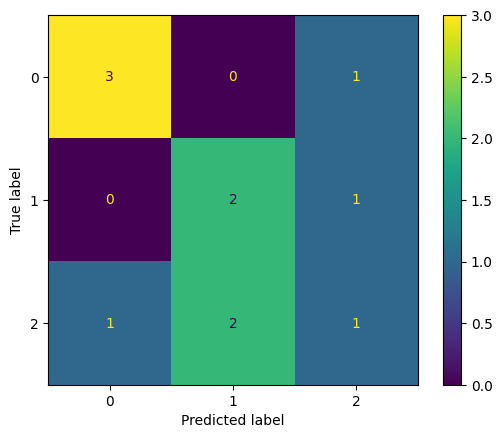

In [17]:
r_modelXG=XGBoost(X_train,y_train,X_test,y_test,True)
r_modelXGP=XGBoostP(X_train,y_train,X_test,y_test,True)

Classification Report: Naive Bayes (GaussianNB)
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.75      1.00      0.86         3
           2       0.67      0.50      0.57         4

    accuracy                           0.73        11
   macro avg       0.72      0.75      0.73        11
weighted avg       0.72      0.73      0.71        11

True: 0, Pred: 0, Probabilities: [9.99999953e-01 4.65391360e-08 1.05876472e-14]
True: 1, Pred: 1, Probabilities: [2.92102121e-17 9.96025525e-01 3.97447454e-03]
True: 0, Pred: 0, Probabilities: [0.57461599 0.41370307 0.01168094]
True: 1, Pred: 1, Probabilities: [5.75468700e-12 1.00000000e+00 1.43058243e-14]
True: 0, Pred: 0, Probabilities: [1.00000000e+00 5.15531981e-11 4.22292887e-13]
True: 2, Pred: 2, Probabilities: [6.79478322e-07 3.68304287e-02 9.63168892e-01]
True: 2, Pred: 0, Probabilities: [9.99874747e-01 1.24614322e-04 6.38971194e-07]
True: 1, Pred: 1, Proba

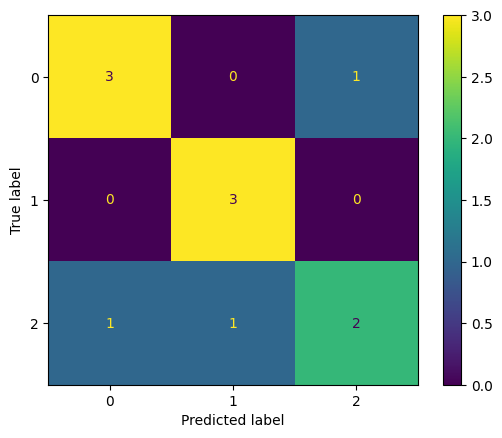

In [18]:
r_model=NaiveBayes(X_train,y_train,X_test,y_test,True)
r_modelP=NaiveBayesP(X_train,y_train,X_test,y_test,True)

Classification Report: SVC
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.67      0.67      0.67         3
           2       0.00      0.00      0.00         4

    accuracy                           0.55        11
   macro avg       0.41      0.56      0.46        11
weighted avg       0.39      0.55      0.45        11

True: 0, Pred: 0, Probabilities: [0.36880524 0.30245188 0.32874288]
True: 1, Pred: 2, Probabilities: [0.15878061 0.50225993 0.33895946]
True: 0, Pred: 0, Probabilities: [0.3805994  0.31023809 0.30916251]
True: 1, Pred: 1, Probabilities: [0.15699617 0.46957605 0.37342778]
True: 0, Pred: 0, Probabilities: [0.46593136 0.18596546 0.34810317]
True: 2, Pred: 0, Probabilities: [0.24734841 0.43624313 0.31640846]
True: 2, Pred: 0, Probabilities: [0.3346537  0.34110912 0.32423718]
True: 1, Pred: 1, Probabilities: [0.19787791 0.42933533 0.37278676]
True: 2, Pred: 1, Probabilities: [0.19054587 0.4

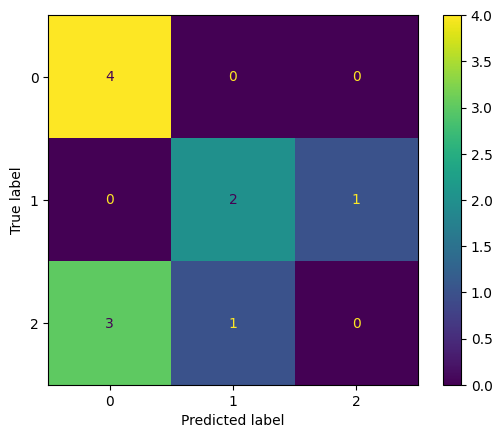

In [19]:
r_modelSVM=SVM(X_train,y_train,X_test,y_test,True)
r_modelSVWP=SVMP(X_train,y_train,X_test,y_test,True)

# Modelling and Classification using bead control

### Using LBP

In [20]:
data=[]

for d in CF_all:
    d.columns=['SV','X','Y','Z']
    data.append([d,1])
for d in KO_all:
    d.columns=['SV','X','Y','Z']
    data.append([d,2])
for d in WT_all:
    d.columns=['SV','X','Y','Z']
    data.append([d,0])




lbp=LBP_3D(data)
features=lbp.extract()


In [21]:
def remove(feat,test,label):
    temp=feat[feat['Label']==label]
    t=temp.sample(n=1, random_state=np.random.randint(0, 1000))

    feat=feat.drop(t.index)
    test=pd.concat([test,t],ignore_index=True)

test=pd.DataFrame()

remove(features,test,0)
remove(features,test,1)
remove(features,test,2)




In [22]:
labels=features['Label']
features=features.drop(columns=['Label'])
features=features.apply(pd.to_numeric, errors='coerce')

features.fillna(0,inplace=True)

In [23]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)



Classification Report: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

True: 2, Pred: 2, Probabilities: [0.01424288 0.00831624 0.9774409 ]
True: 0, Pred: 0, Probabilities: [0.98161584 0.01006192 0.00832226]
True: 2, Pred: 2, Probabilities: [0.00598402 0.00862125 0.9853947 ]
True: 1, Pred: 1, Probabilities: [0.01191581 0.98432606 0.00375816]
True: 1, Pred: 1, Probabilities: [0.01582094 0.98211944 0.00205968]
True: 1, Pred: 1, Probabilities: [0.0353551  0.9443112  0.02033377]
True: 0, Pred: 0, Probabilities: [0.9755138  0.01404775 0.01043845]
True: 2, Pred: 2, Probabilities: [0.0202875  0.02326309 0.9564494 ]
True: 0, Pred: 0, Probabilities: [0.9860491 

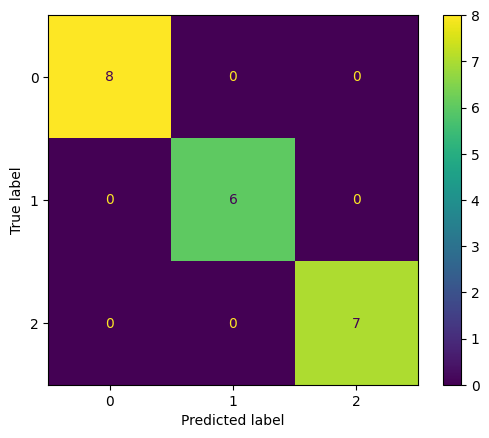

In [24]:
modelXG=XGBoost(X_train,y_train,X_test,y_test,True)
modelXGP=XGBoostP(X_train,y_train,X_test,y_test,True)

Classification Report: Naive Bayes (GaussianNB)
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.80      0.67      0.73         6
           2       0.75      0.86      0.80         7

    accuracy                           0.71        21
   macro avg       0.72      0.72      0.72        21
weighted avg       0.72      0.71      0.71        21

True: 2, Pred: 2, Probabilities: [0.31020686 0.05534668 0.63444646]
True: 0, Pred: 0, Probabilities: [9.99919685e-01 6.69142690e-08 8.02481138e-05]
True: 2, Pred: 2, Probabilities: [6.41312313e-09 2.58160754e-12 9.99999994e-01]
True: 1, Pred: 1, Probabilities: [6.16407386e-15 1.00000000e+00 1.30138184e-32]
True: 1, Pred: 1, Probabilities: [1.04538468e-08 9.99999990e-01 3.56511725e-22]
True: 1, Pred: 0, Probabilities: [7.93676415e-01 2.06323299e-01 2.86141869e-07]
True: 0, Pred: 0, Probabilities: [0.8661988  0.13274572 0.00105548]
True: 2, Pred: 0, Probabilities: [0

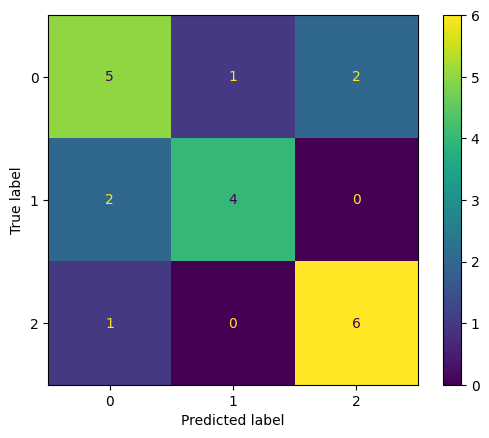

In [25]:
model=NaiveBayes(X_train,y_train,X_test,y_test,True)
modelP=NaiveBayesP(X_train,y_train,X_test,y_test,True)

Classification Report: SVC
              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       1.00      0.50      0.67         6
           2       0.50      0.57      0.53         7

    accuracy                           0.57        21
   macro avg       0.67      0.57      0.59        21
weighted avg       0.64      0.57      0.58        21

True: 2, Pred: 0, Probabilities: [0.34064734 0.18812896 0.47122371]
True: 0, Pred: 2, Probabilities: [0.21802969 0.07227957 0.70969074]
True: 2, Pred: 0, Probabilities: [0.36556621 0.30085032 0.33358347]
True: 1, Pred: 1, Probabilities: [0.55274239 0.41993287 0.02732474]
True: 1, Pred: 1, Probabilities: [0.56819457 0.40822676 0.02357867]
True: 1, Pred: 0, Probabilities: [0.41193895 0.3780063  0.21005476]
True: 0, Pred: 0, Probabilities: [0.40735446 0.40068491 0.19196063]
True: 2, Pred: 0, Probabilities: [0.42401829 0.41466151 0.1613202 ]
True: 0, Pred: 0, Probabilities: [0.41237954 0.3

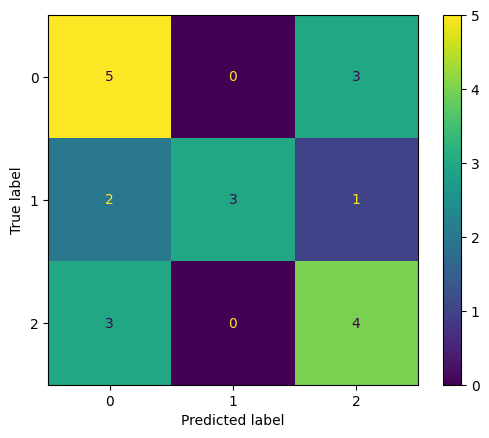

In [26]:
modelSVM=SVM(X_train,y_train,X_test,y_test,True)
modelSVWP=SVMP(X_train,y_train,X_test,y_test,True)

## Using report features

In [27]:
r_feat=pd.DataFrame()

for d in CF_report_all:
    d['Label']=1
    r_feat=pd.concat([r_feat,d],ignore_index=True)
for d in WT_report_all:
    d['Label']=0
    r_feat=pd.concat([r_feat,d],ignore_index=True)
for d in KO_report_all:
    d['Label']=2
    r_feat=pd.concat([r_feat,d],ignore_index=True)




In [28]:
test_r=pd.DataFrame()
remove(r_feat,test_r,0)

remove(r_feat,test_r,1)
remove(r_feat,test_r,2)


In [29]:
labels=r_feat['Label']
r_feat=r_feat.drop(columns=['Label'])
r_feat=r_feat.apply(pd.to_numeric, errors='coerce')

r_feat.fillna(0,inplace=True)



In [30]:

X_train, X_test, y_train, y_test = train_test_split(features.values, labels, test_size=0.2, random_state=42,stratify=labels)


Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00         6
           2       1.00      0.86      0.92         7

    accuracy                           0.95        21
   macro avg       0.96      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21

True: 2, Pred: 2, Probabilities: [0.01022811 0.00914648 0.9806254 ]
True: 0, Pred: 0, Probabilities: [0.98137915 0.01564095 0.00297995]
True: 2, Pred: 2, Probabilities: [0.00950819 0.01368975 0.97680205]
True: 1, Pred: 1, Probabilities: [0.00134874 0.9887982  0.0098531 ]
True: 1, Pred: 1, Probabilities: [0.00277522 0.9866753  0.01054945]
True: 1, Pred: 1, Probabilities: [0.01470161 0.9692376  0.01606084]
True: 0, Pred: 0, Probabilities: [0.9836516  0.00856914 0.00777925]
True: 2, Pred: 2, Probabilities: [0.0067239  0.00285948 0.99041665]
True: 0, Pred: 0, Probabilities: [0.9803216 

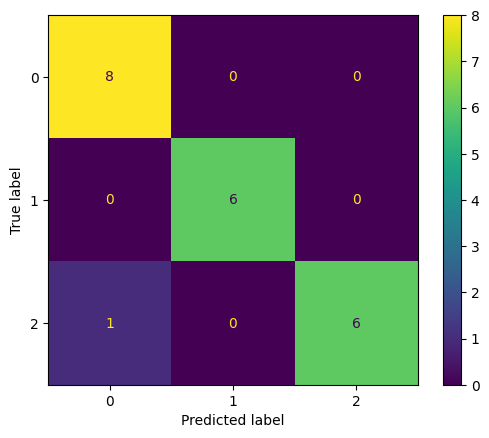

In [31]:
r_modelXG=XGBoost(X_train,y_train,X_test,y_test,True)
r_modelXGP=XGBoostP(X_train,y_train,X_test,y_test,True)

Classification Report: Naive Bayes (GaussianNB)
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.67      0.67      0.67         6
           2       0.45      0.71      0.56         7

    accuracy                           0.52        21
   macro avg       0.54      0.54      0.52        21
weighted avg       0.53      0.52      0.50        21

True: 2, Pred: 0, Probabilities: [9.87531896e-01 2.09088099e-04 1.22590161e-02]
True: 0, Pred: 1, Probabilities: [0.00142095 0.95827346 0.04030559]
True: 2, Pred: 2, Probabilities: [0.2042889 0.0099914 0.7857197]
True: 1, Pred: 1, Probabilities: [3.10467157e-36 1.00000000e+00 9.53838008e-13]
True: 1, Pred: 1, Probabilities: [2.77880608e-19 9.99999995e-01 4.57906754e-09]
True: 1, Pred: 1, Probabilities: [3.62267136e-06 7.60627902e-01 2.39368476e-01]
True: 0, Pred: 2, Probabilities: [0.00738478 0.02070101 0.97191421]
True: 2, Pred: 2, Probabilities: [2.07653740e-02 2

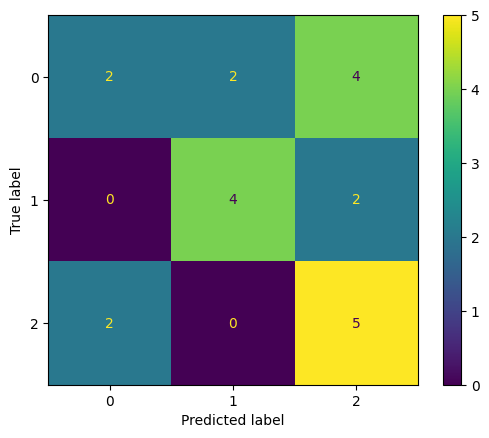

In [33]:
r_model=NaiveBayes(X_train,y_train,X_test,y_test,True)
r_modelP=NaiveBayesP(X_train,y_train,X_test,y_test,True)

Classification Report: SVC
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       1.00      0.50      0.67         6
           2       0.33      0.29      0.31         7

    accuracy                           0.52        21
   macro avg       0.61      0.51      0.52        21
weighted avg       0.59      0.52      0.52        21

True: 2, Pred: 0, Probabilities: [0.38252915 0.35114579 0.26632505]
True: 0, Pred: 0, Probabilities: [0.71259294 0.16113658 0.12627049]
True: 2, Pred: 0, Probabilities: [0.36253853 0.32844121 0.30902026]
True: 1, Pred: 1, Probabilities: [0.00488948 0.47653486 0.51857566]
True: 1, Pred: 1, Probabilities: [0.01341369 0.43704294 0.54954337]
True: 1, Pred: 2, Probabilities: [0.26441272 0.39262771 0.34295957]
True: 0, Pred: 0, Probabilities: [0.4643707  0.24645517 0.28917413]
True: 2, Pred: 0, Probabilities: [0.86212667 0.04759414 0.09027919]
True: 0, Pred: 2, Probabilities: [0.16592475 0.4

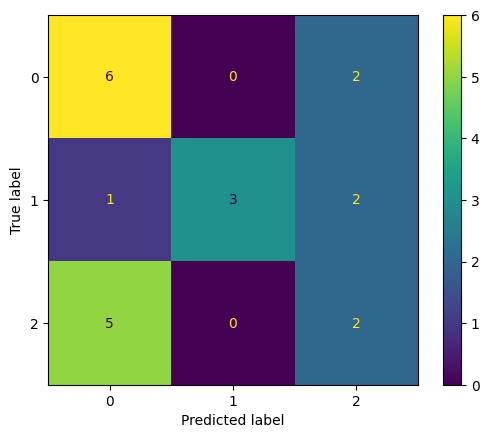

In [34]:
r_modelSVM=SVM(X_train,y_train,X_test,y_test,True)
r_modelSVWP=SVMP(X_train,y_train,X_test,y_test,True)